# CNN Architecture for Predicting s2z

In [1]:
import numpy as np
np.set_printoptions(threshold=np.nan)
import random
import h5py as h5
import tensorflow as tf
import matplotlib.pyplot as plt
from helper_functions import *

Set up CNN architecture

In [2]:
#Main placeholders
x = tf.placeholder(tf.float32, shape = [None, 30000])
y = tf.placeholder(tf.float32, shape = [None, 3])

#Reshape input
inp = tf.reshape(x, [-1, 30000, 1, 1])

#Convolutional layer 1,2
w_conv1 = weight('w_conv1', [80, 1, 1, 64])
b_conv1 = bias('b_conv1', [64])
conv1 = tf.nn.relu(conv(inp, w_conv1) + b_conv1)

w_conv2 = weight('w_conv2', [20, 1, 64, 64])
b_conv2 = bias('b_conv2', [64])
conv2 = tf.nn.relu(conv(conv1, w_conv2) + b_conv2)

#Max pool 1
conv2 = maxPool(conv2, 5)
print(conv2.shape)

#Convolutional layer 3,4
w_conv3 = weight('w_conv3', [5, 1, 64, 128])
b_conv3 = bias('b_conv3', [128])
conv3 = tf.nn.relu(conv(conv2, w_conv3) + b_conv3)

w_conv4 = weight('w_conv4', [5, 1, 128, 128])
b_conv4 = bias('b_conv4', [128])
conv4 = tf.nn.relu(conv(conv3, w_conv4) + b_conv4)

#Max pool 2
conv4 = maxPool(conv4, 5)
print(conv4.shape)

#Convolutional layer 5
w_conv5 = weight('w_conv5', [5, 1, 128, 256])
b_conv5 = bias('b_conv5', [256])
conv5 = tf.nn.relu(conv(conv4, w_conv5) + b_conv5)

#Max pool 3
conv5 = maxPool(conv5, 5)
print(conv5.shape)

#Convolutional layer 6
w_conv6 = weight('w_conv6', [5, 1, 256, 256])
b_conv6 = bias('b_conv6', [256])
conv6 = tf.nn.relu(conv(conv5, w_conv6) + b_conv6)

#Max pool 4
conv6 = maxPool(conv6, 5)
print(conv6.shape)

#Convolution layer 7
w_conv7 = weight('w_conv7', [5, 1, 256, 256])
b_conv7 = bias('b_conv7', [256])
conv7 = tf.nn.relu(conv(conv6, w_conv7) + b_conv7)

#Max pool 5
conv7 = maxPool(conv7, 4)
print(conv7.shape)

#Flatten
flat = tf.reshape(conv7, [-1, 12 * 256])

#Fully connected layer
w_fc = weight('w_fc', [12 * 256, 20])
b_fc = bias('b_fc', [20])
fc = tf.nn.relu(tf.matmul(flat, w_fc) + b_fc)

#Output layer
w_fc1 = weight('w_fc1', [20, 3])
b_fc1 = bias('b_fc1', [3])

#prediction = tf.nn.tanh(tf.matmul(fc, w_fc1) + b_fc1)
prediction = (tf.matmul(fc, w_fc1) + b_fc1)

(?, 6000, 1, 64)
(?, 1200, 1, 128)
(?, 240, 1, 256)
(?, 48, 1, 256)
(?, 12, 1, 256)


Train CNN model

In [3]:
def train(lr, batch_size, threshold, epochs):
    
    print("\n######################################")
    print("Learning rate: " + str(lr) + " Batch size: " + str(batch_size))
    print("######################################\n")

    cost = (tf.losses.mean_squared_error(prediction, y))

    re_q = tf.divide(tf.abs(tf.subtract(prediction[:,0], y[:,0])), y[:,0]) * 100  #Relative error
    re_s1z = tf.divide(tf.abs(tf.subtract(prediction[:,1], y[:,1])), y[:,1]) * 100  #Relative error
    re_s2z = tf.divide(tf.abs(tf.subtract(prediction[:,2], y[:,2])), (y[:,2])) * 100  #Relative error

    q = tf.reduce_mean(re_q)
    s1z = tf.reduce_mean(re_s1z)
    s2z = tf.reduce_mean(re_s2z)

    optimizer = tf.train.AdamOptimizer(lr).minimize(cost)

    # config = tf.ConfigProto(device_count = {'GPU': 0}) #Use CPU instead of GPU

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        sample, label = process_data('train50.h5')
        test_samples, test_labels = process_data('test.h5')

        graph_cost = []
        graph_epoch = []
        total_size = (sample.shape)[0]

        for epoch in range(epochs):
            cost_ = 0
            i = 0

            temp_sample = np.copy(sample)
            temp_label = np.copy(label)

            np.random.seed(epoch%1000)
            np.random.shuffle(temp_sample)
            np.random.seed(epoch%1000)
            np.random.shuffle(temp_label)

            #Minibatches
            while i < total_size:
                if i + batch_size < test_samples.shape[0]:
                    batch_sample = temp_sample[i:i+batch_size]
                    batch_label = temp_label[i:i+batch_size]
                else:
                    batch_sample = temp_sample[i:]
                    batch_label = temp_label[i:]

                _, c = sess.run([optimizer, cost], feed_dict = {x: batch_sample, y: batch_label})
                i += batch_size
                cost_ += c/(total_size/batch_size)

            if epoch % 10 == 0:
                graph_epoch.append(epoch)
                graph_cost.append(c)
            
            if epoch % 50 == 0:
                print(str(epoch + 50) + " out of " + str(epochs) + " completed. Loss: " + str(c))


        print("Relative Error for s2z on training set: " +  str(s2z.eval({x: sample, y: label})) + "%")
        print("Relative Error for s2z on test set: " +  str(s2z.eval({x: test_samples, y: test_labels})) + "%")
        
        correct = (re_s2z < threshold)                          #see if the difference is less than the threshold
        correct = tf.cast(correct, tf.float32)                  #convert boolean tensor to float32
        accuracy = tf.reduce_mean(correct, axis=None) * 100     #convert to a percentage

        print("Training set accuracy (less than " + str(threshold) + "% relative error): " + str(accuracy.eval({x: sample, y: label})) + "%")
        print("Test set accuracy (less than " + str(threshold) + "% relative error): " + str(accuracy.eval({x: test_samples, y: test_labels})) + "%")
        
        plt.plot(graph_epoch, graph_cost)
        plt.show()

Test various hyperparameters


######################################
Learning rate: 0.0001 Batch size: 4
######################################

50 out of 250 completed. Loss: 0.0677019
100 out of 250 completed. Loss: 4.45333e-06
150 out of 250 completed. Loss: 1.28618e-07
200 out of 250 completed. Loss: 5.88617e-06
250 out of 250 completed. Loss: 7.03285e-05
Relative Error for s2z on training set: 1.33959%
Relative Error for s2z on test set: 5.84925%
Training set accuracy (less than 5% relative error): 100.0%
Test set accuracy (less than 5% relative error): 71.4286%


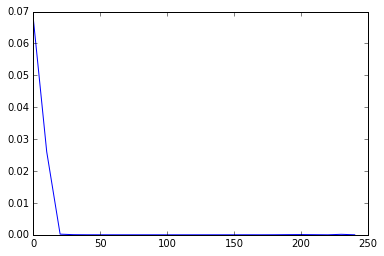


######################################
Learning rate: 0.0001 Batch size: 5
######################################

50 out of 250 completed. Loss: 0.0408645
100 out of 250 completed. Loss: 8.76807e-06
150 out of 250 completed. Loss: 1.64204e-07
200 out of 250 completed. Loss: 1.03212e-06
250 out of 250 completed. Loss: 1.65156e-05
Relative Error for s2z on training set: 0.186317%
Relative Error for s2z on test set: 3.72934%
Training set accuracy (less than 5% relative error): 100.0%
Test set accuracy (less than 5% relative error): 85.7143%


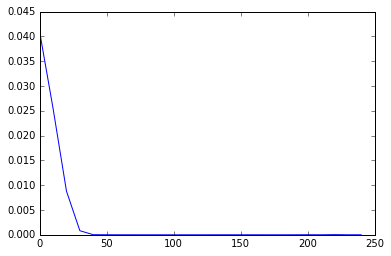


######################################
Learning rate: 0.0001 Batch size: 8
######################################

50 out of 250 completed. Loss: 0.047748
100 out of 250 completed. Loss: 6.14206e-05
150 out of 250 completed. Loss: 2.85799e-05
200 out of 250 completed. Loss: 6.12324e-06
250 out of 250 completed. Loss: 3.65059e-08
Relative Error for s2z on training set: 0.0393343%
Relative Error for s2z on test set: 7.54643%
Training set accuracy (less than 5% relative error): 100.0%
Test set accuracy (less than 5% relative error): 71.4286%


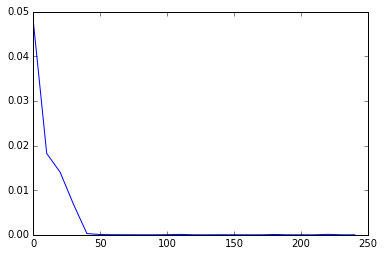


######################################
Learning rate: 0.0001 Batch size: 10
######################################

50 out of 250 completed. Loss: 0.0260913
100 out of 250 completed. Loss: 0.00228277
150 out of 250 completed. Loss: 5.72845e-06
200 out of 250 completed. Loss: 1.56456e-07
250 out of 250 completed. Loss: 1.61735e-08
Relative Error for s2z on training set: 0.012821%
Relative Error for s2z on test set: 4.37509%
Training set accuracy (less than 5% relative error): 100.0%
Test set accuracy (less than 5% relative error): 85.7143%


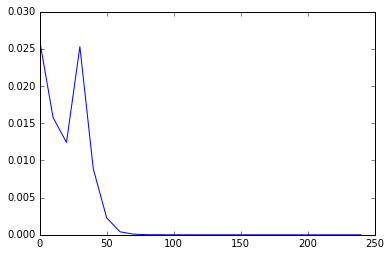

In [5]:
lrs = [.0001]
sizes = [4, 5, 8, 10]

for lr in lrs: 
    for size in sizes:
        train(lr = lr, batch_size = size, threshold = 5, epochs = 250)
